In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
csv_path = 'Luxury watch.csv'
df = pd.read_csv(csv_path, encoding='utf-8', low_memory=False)

print("Shape del dataset:", df.shape)
print("Columnas:", df.columns.tolist())
df.head()

Shape del dataset: (507, 14)
Columnas: ['Brand', 'Model', 'Case Material', 'Strap Material', 'Movement Type', 'Water Resistance', 'Case Diameter (mm)', 'Case Thickness (mm)', 'Band Width (mm)', 'Dial Color', 'Crystal Material', 'Complications', 'Power Reserve', 'Price (USD)']


,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,"9,500"
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,"5,800"
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,"4,200"
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,"7,900"
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,NaN,NaN,"2,800"


In [6]:
target = 'Price (USD)'

df[target] = pd.to_numeric(
    df[target].astype(str).str.replace(',', '').replace('', np.nan),
    errors='coerce'
)

print("\nDescripción estadística del precio:")
print(df[target].describe())


Descripción estadística del precio:
count      506.000000
mean     12082.964427
std      10419.816968
min        495.000000
25%       5500.000000
50%       8350.000000
75%      16450.000000
max      70000.000000
Name: Price (USD), dtype: float64


EDA

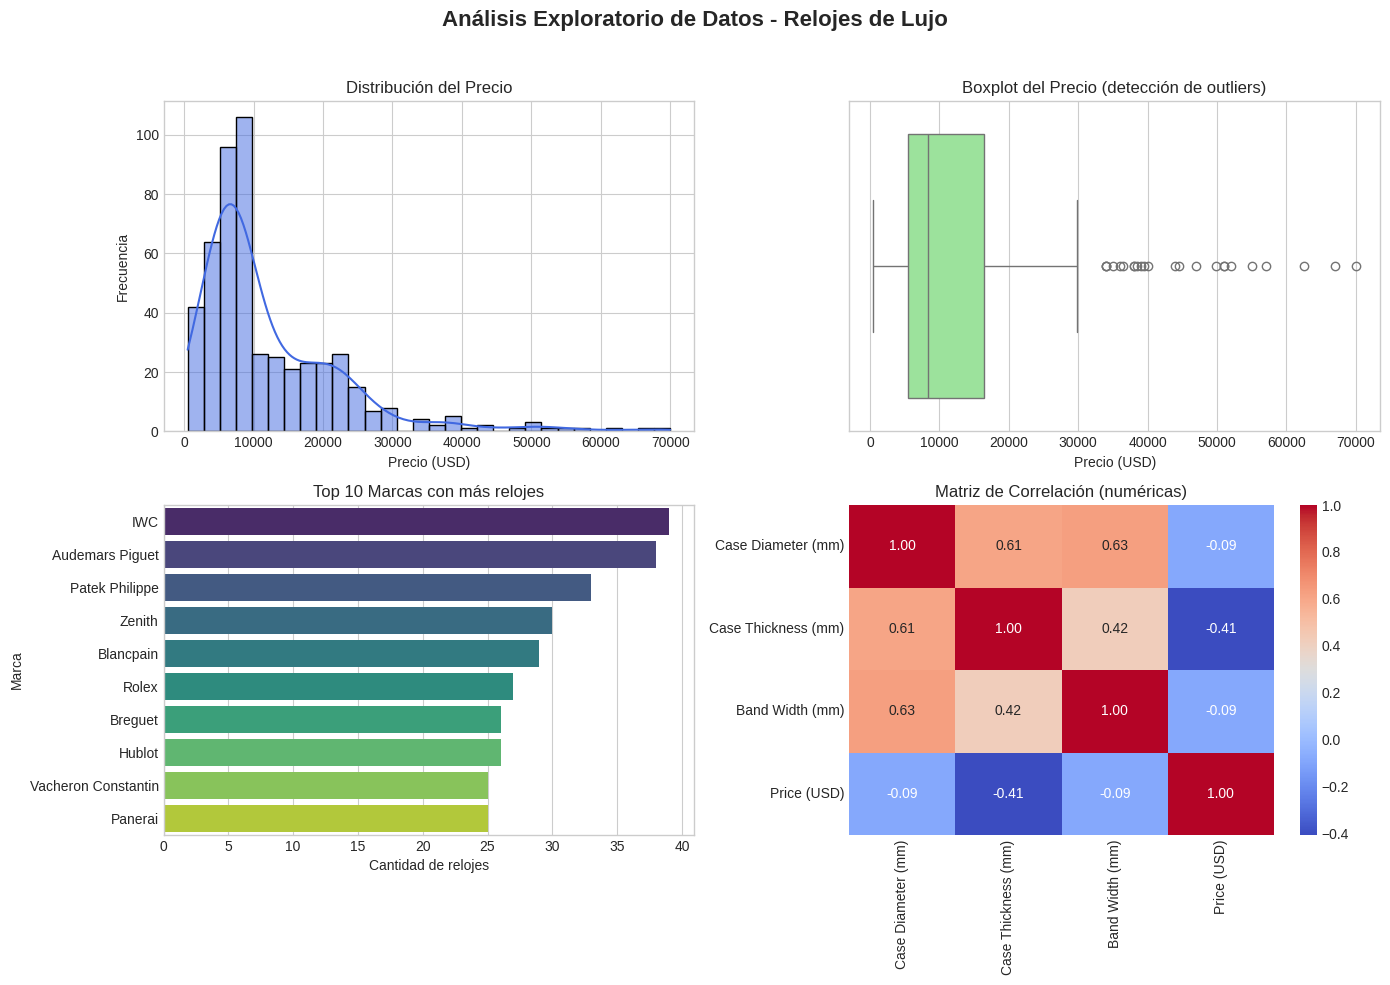

In [7]:
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Análisis Exploratorio de Datos - Relojes de Lujo", fontsize=16, fontweight="bold")

sns.histplot(df[target], bins=30, kde=True, color="royalblue", ax=axes[0,0])
axes[0,0].set_title("Distribución del Precio")
axes[0,0].set_xlabel("Precio (USD)")
axes[0,0].set_ylabel("Frecuencia")

sns.boxplot(x=df[target], color="lightgreen", ax=axes[0,1])
axes[0,1].set_title("Boxplot del Precio (detección de outliers)")
axes[0,1].set_xlabel("Precio (USD)")
axes[0,1].set_ylabel("")

if 'Brand' in df.columns:
    top_brands = df['Brand'].value_counts().head(10)
    sns.barplot(
    x=top_brands.values,
    y=top_brands.index,
    hue=top_brands.index,
    palette="viridis",
    dodge=False,
    legend=False,
    ax=axes[1,0]
    )
    axes[1,0].set_title("Top 10 Marcas con más relojes")
    axes[1,0].set_xlabel("Cantidad de relojes")
    axes[1,0].set_ylabel("Marca")
else:
    axes[1,0].text(0.3, 0.5, "No existe columna 'Brand'", fontsize=12)
    axes[1,0].set_axis_off()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1,1])
    axes[1,1].set_title("Matriz de Correlación (numéricas)")
else:
    axes[1,1].text(0.3, 0.5, "No hay variables numéricas suficientes", fontsize=12)
    axes[1,1].set_axis_off()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [8]:
features = [c for c in df.columns if c != target]

numeric_feats = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_feats = [c for c in features if df[c].dtype == object or df[c].dtype.name == 'category']

selected = []
selected.extend(numeric_feats[:8])
for c in cat_feats:
    if df[c].nunique(dropna=True) <= 20 and len(selected) < 10:
        selected.append(c)

print("Características seleccionadas:", selected)

df_model = df[selected + [target]].dropna(subset=[target])
print("Registros disponibles para modelado:", df_model.shape[0])

X = df_model[selected]
y = df_model[target]

Características seleccionadas: ['Case Diameter (mm)', 'Case Thickness (mm)', 'Band Width (mm)', 'Case Material', 'Strap Material', 'Movement Type', 'Water Resistance', 'Dial Color', 'Crystal Material']
Registros disponibles para modelado: 506


In [9]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results[name] = {
        'RMSE (test)': rmse,
        'MAE (test)': mae,
        'R² (test)': r2
    }

In [11]:
results_df = pd.DataFrame(results).T
print("\nComparación de modelos:")
print(results_df)


Comparación de modelos:
                  RMSE (test)   MAE (test)  R² (test)
LinearRegression  5128.942681  3416.885861   0.691566
RandomForest      4832.187201  2643.493888   0.726224


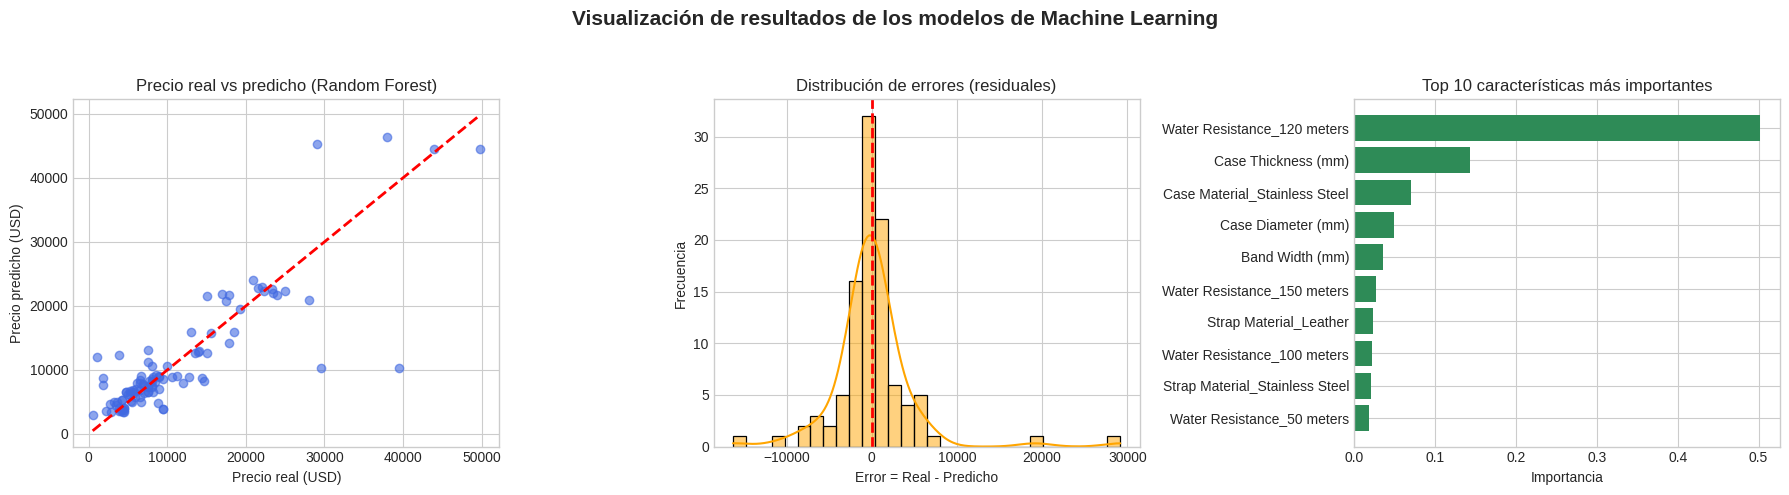

In [12]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Visualización de resultados de los modelos de Machine Learning", fontsize=15, fontweight="bold")

rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', models['RandomForest'])])
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)

axes[0].scatter(y_test, pred_rf, alpha=0.6, color='royalblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title("Precio real vs predicho (Random Forest)")
axes[0].set_xlabel("Precio real (USD)")
axes[0].set_ylabel("Precio predicho (USD)")

residuals = y_test - pred_rf
sns.histplot(residuals, bins=30, kde=True, color='orange', ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_title("Distribución de errores (residuales)")
axes[1].set_xlabel("Error = Real - Predicho")
axes[1].set_ylabel("Frecuencia")

rf = rf_model.named_steps['regressor']
encoded_feats = (
    rf_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_cols)
)
feature_names = np.concatenate([numeric_cols, encoded_feats])
importances = rf.feature_importances_

indices = np.argsort(importances)[-10:]
axes[2].barh(range(len(indices)), importances[indices], color='seagreen')
axes[2].set_yticks(range(len(indices)))
axes[2].set_yticklabels(feature_names[indices])
axes[2].set_title("Top 10 características más importantes")
axes[2].set_xlabel("Importancia")

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


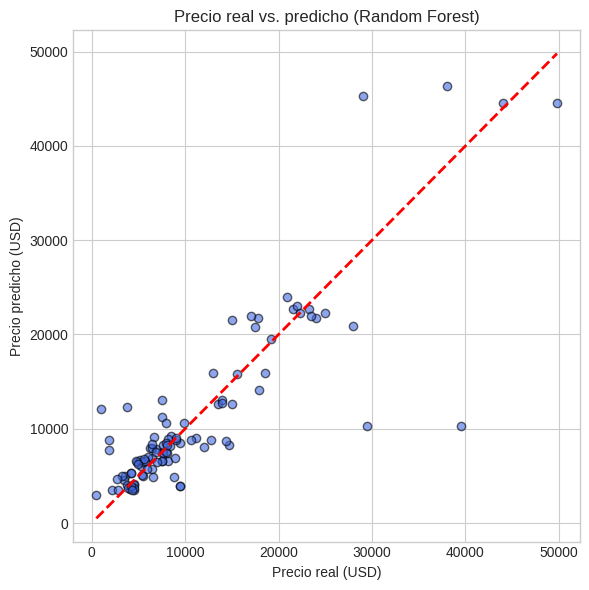

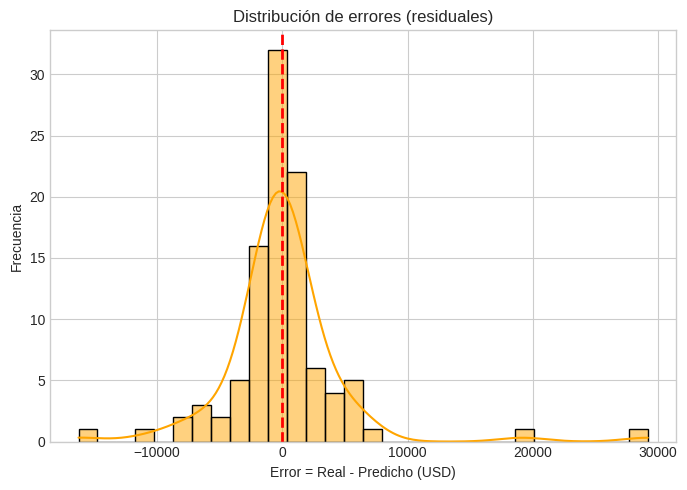

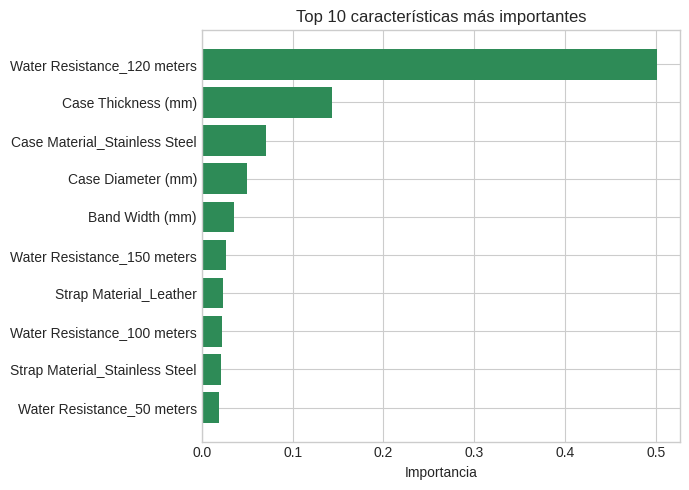

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_rf, alpha=0.6, color='royalblue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Precio real vs. predicho (Random Forest)")
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio predicho (USD)")
plt.tight_layout()
plt.savefig("real_vs_predicho.png", dpi=300, bbox_inches="tight")
plt.show()

residuals = y_test - pred_rf
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.title("Distribución de errores (residuales)")
plt.xlabel("Error = Real - Predicho (USD)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("residuales.png", dpi=300, bbox_inches="tight")
plt.show()

rf = rf_model.named_steps['regressor']
encoded_feats = (
    rf_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_cols)
)
feature_names = np.concatenate([numeric_cols, encoded_feats])
importances = rf.feature_importances_

indices = np.argsort(importances)[-10:]
plt.figure(figsize=(7,5))
plt.barh(range(len(indices)), importances[indices], color='seagreen')
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top 10 características más importantes")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig("importancia_caracteristicas.png", dpi=300, bbox_inches="tight")
plt.show()

Nuevo df


In [41]:
new_data_path = 'watch_db.csv'
df_new = pd.read_csv("watch_db.csv", 
                 encoding="latin1", 
                 sep=";", 
                 engine="python").copy()

df_new.shape

(40155, 18)

In [42]:
df_new.describe()

,Brand,Family,Name,Reference,Movement_Caliber,Movement_Functions,Limited,Case Material,Glass,Back,Shape,Diameter,Height,W/R,Dial Color,Indexes,Hands,Description
count,35860,35859,35859,35860,35860,35860,35860,35860,35860,35860,35860,35860,35860,35860,35860,35519,35860,35839
unique,163,707,30217,35811,2364,716,322,63,6,6,9,296,636,39,33,12,23,27938
top,Breitling,Galactic,Chronomat 41,4.0469E+12,Breitling caliber Caliber B01,"Hours, Minutes, Seconds | Date",No,Stainless Steel,Sapphire,Closed,Round,42.00 mm,Bilgi Yok,100.00 m,Black,Stick / Dot,Stick,The Datejust 31 is a smaller version of the Da...
freq,4270,1065,43,3,858,7475,31350,18779,34658,19232,30096,3907,15507,12220,9605,16044,17054,574


In [43]:
rename_map = {
    'Diameter': 'Case Diameter (mm)',
    'Height': 'Case Thickness (mm)',
    'W/R': 'Water Resistance',
    'Glass': 'Crystal Material'
}

df_new.rename(columns=rename_map)
df_new.head()

,Brand,Family,Name,Reference,Movement_Caliber,Movement_Functions,Limited,Case Material,Glass,Back,Shape,Diameter,Height,W/R,Dial Color,Indexes,Hands,Description
0,Breitling,Navitimer,Navitimer GMT 41 Automatic Red Gold / Black / ...,R323101A1B1P1,Breitling caliber Caliber 32,"Hours, Minutes, Seconds, Additional 24 Hour Ha...","Yes, 50 units",Red Gold,Sapphire,Closed,Round,41.00 mm,11.60 mm,30.00 m,Black,Stick / Dot,Syringe,The Breitling Navitimer Automatic GMT 41 R3231...
1,Patek Philippe,Nautilus,Nautilus 7118 Rose Gold / Snow-Set,7118/1450G-001,Patek Philippe caliber 324 S,"Hours, Minutes, Seconds",No,Diamond,Sapphire,Open,Cushion,35.20 mm,8.62 mm,60.00 m,Diamonds,Mixed,Alpha,The Patek Philippe Nautilus 7118/1450G-001 deb...
2,Patek Philippe,Nautilus,Nautilus 7118 Rose Gold / Brown,7118/1R-010,Patek Philippe caliber 324 S C,"Hours, Minutes, Seconds | Date",No,Rose Gold,Sapphire,Open,Cushion,35.20 mm,8.62 mm,60.00 m,Silver,Mixed,Alpha,The Patek Philippe Nautilus 7118/1R-010 debute...
3,Patek Philippe,Nautilus,Nautilus 7118 Rose Gold / Silver,7118/1R-001,Patek Philippe caliber 324 S C,"Hours, Minutes, Seconds | Date",No,Rose Gold,Sapphire,Open,Cushion,35.20 mm,8.62 mm,60.00 m,Silver,Mixed,Alpha,The Patek Philippe Nautilus 7118/1R-001 debute...
4,Patek Philippe,Nautilus,Nautilus 7010 Rose Gold / Purple,7010/1R-013,Patek Philippe caliber E23-250 S C,"Hours, Minutes, Seconds | Date",No,Rose Gold,Sapphire,Closed,Cushion,32.00 mm,6.90 mm,60.00 m,Purple,Mixed,Stick,The Patek Philippe Nautilus 7010/1R-013 debute...


In [ ]:
df_new = pd.read_csv("watch_db.csv", 
                 encoding="latin1", 
                 sep=";", 
                 engine="python").copy()

rename_map = {
    'Diameter': 'Case Diameter (mm)',
    'Height': 'Case Thickness (mm)',
    'W/R': 'Water Resistance',
    'Glass': 'Crystal Material'
}

df_new = df_new.rename(columns=rename_map)

cols_mm = ['Case Diameter (mm)', 'Case Thickness (mm)']

for col in cols_mm:
    if col in df.columns:
        df_new[col] = (
            df_new[col]
            .astype(str)
            .str.replace('mm', '', regex=False)
            .str.replace('Bilgi Yok', '', regex=False)
            .str.strip()
            .replace('', np.nan)
            .astype(float)
        )

df_new['Water Resistance'] = (
    df_new['Water Resistance']
    .astype(str)
    .str.replace('m', '', regex=False)
    .str.replace('Bilgi Yok', '', regex=False)
    .str.strip()                          
    .replace('', np.nan)
    .astype(float)                        
)

print("Columnas disponibles tras renombrado (primeras 20):")
print(df_new.columns.tolist()[:20])
df_new.head()

Columnas disponibles tras renombrado (primeras 20):
['Brand', 'Family', 'Name', 'Reference', 'Movement_Caliber', 'Movement_Functions', 'Limited', 'Case Material', 'Crystal Material', 'Back', 'Shape', 'Case Diameter (mm)', 'Case Thickness (mm)', 'Water Resistance', 'Dial Color', 'Indexes', 'Hands', 'Description']


,Brand,Family,Name,Reference,Movement_Caliber,Movement_Functions,Limited,Case Material,Crystal Material,Back,Shape,Case Diameter (mm),Case Thickness (mm),Water Resistance,Dial Color,Indexes,Hands,Description
0,Breitling,Navitimer,Navitimer GMT 41 Automatic Red Gold / Black / ...,R323101A1B1P1,Breitling caliber Caliber 32,"Hours, Minutes, Seconds, Additional 24 Hour Ha...","Yes, 50 units",Red Gold,Sapphire,Closed,Round,41.0,11.60,30.0,Black,Stick / Dot,Syringe,The Breitling Navitimer Automatic GMT 41 R3231...
1,Patek Philippe,Nautilus,Nautilus 7118 Rose Gold / Snow-Set,7118/1450G-001,Patek Philippe caliber 324 S,"Hours, Minutes, Seconds",No,Diamond,Sapphire,Open,Cushion,35.2,8.62,60.0,Diamonds,Mixed,Alpha,The Patek Philippe Nautilus 7118/1450G-001 deb...
2,Patek Philippe,Nautilus,Nautilus 7118 Rose Gold / Brown,7118/1R-010,Patek Philippe caliber 324 S C,"Hours, Minutes, Seconds | Date",No,Rose Gold,Sapphire,Open,Cushion,35.2,8.62,60.0,Silver,Mixed,Alpha,The Patek Philippe Nautilus 7118/1R-010 debute...
3,Patek Philippe,Nautilus,Nautilus 7118 Rose Gold / Silver,7118/1R-001,Patek Philippe caliber 324 S C,"Hours, Minutes, Seconds | Date",No,Rose Gold,Sapphire,Open,Cushion,35.2,8.62,60.0,Silver,Mixed,Alpha,The Patek Philippe Nautilus 7118/1R-001 debute...
4,Patek Philippe,Nautilus,Nautilus 7010 Rose Gold / Purple,7010/1R-013,Patek Philippe caliber E23-250 S C,"Hours, Minutes, Seconds | Date",No,Rose Gold,Sapphire,Closed,Cushion,32.0,6.90,60.0,Purple,Mixed,Stick,The Patek Philippe Nautilus 7010/1R-013 debute...


In [76]:
df_new.shape

(40155, 21)

In [61]:
def to_numeric_safe(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '').str.strip(), errors='coerce')

for col in ['Case Diameter (mm)', 'Case Thickness (mm)']:
    if col in df_new.columns:
        df_new[col] = to_numeric_safe(df_new[col])

try:
    expected_features = X.columns.tolist()
except NameError:
    raise RuntimeError("La variable `X` (features del modelo) no existe en memoria. "
                       "Ejecuta primero la celda donde defines X, preprocesamiento y entrenas rf_model.")

missing_cols = [col for col in expected_features if col not in df_new.columns]
if missing_cols:
    print(f"Columnas faltantes detectadas y creadas vacías: {missing_cols}")
    for col in missing_cols:
        df_new[col] = np.nan

df_for_pred = df_new[expected_features].copy()

df_for_pred.head()

Columnas faltantes detectadas y creadas vacías: ['Band Width (mm)', 'Strap Material', 'Movement Type']


,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Case Material,Strap Material,Movement Type,Water Resistance,Dial Color,Crystal Material
0,41.0,11.60,NaN,Red Gold,NaN,NaN,30.0,Black,Sapphire
1,35.2,8.62,NaN,Diamond,NaN,NaN,60.0,Diamonds,Sapphire
2,35.2,8.62,NaN,Rose Gold,NaN,NaN,60.0,Silver,Sapphire
3,35.2,8.62,NaN,Rose Gold,NaN,NaN,60.0,Silver,Sapphire
4,32.0,6.90,NaN,Rose Gold,NaN,NaN,60.0,Purple,Sapphire


In [77]:
if 'rf_model' not in globals():
    raise RuntimeError("El pipeline `rf_model` no está en memoria. Ejecuta la celda donde entrenas y defines `rf_model` (pipeline con preprocessor y RandomForest).")

preds = rf_model.predict(df_for_pred)

df_out = df_new.copy()
df_out['Predicted Price (USD)'] = preds


display(df_out[['Predicted Price (USD)']].head())
print("Resumen estadístico de precios predichos:")
print(df_out['Predicted Price (USD)'].describe())

,Predicted Price (USD)
0,6665.833333
1,17955.666667
2,22386.666667
3,22386.666667
4,21278.000000


Resumen estadístico de precios predichos:
count    40155.000000
mean      7659.127924
std       3581.138070
min       4002.555556
25%       5623.000000
50%       6868.833333
75%       7691.333333
max      28724.366667
Name: Predicted Price (USD), dtype: float64


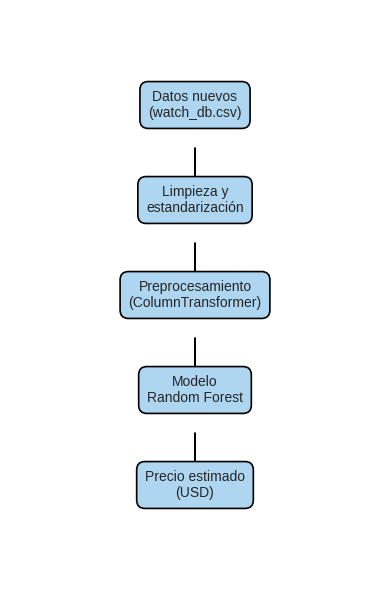

In [72]:
plt.figure(figsize=(4, 6))
plt.axis('off')

# Etapas del pipeline (de arriba a abajo)
stages = [
    "Datos nuevos\n(watch_db.csv)",
    "Limpieza y\nestandarización",
    "Preprocesamiento\n(ColumnTransformer)",
    "Modelo\nRandom Forest",
    "Precio estimado\n(USD)"
]

# Posiciones verticales (de arriba a abajo)
y_positions = list(range(len(stages)))[::-1]

# Dibujar cajas
for i, stage in enumerate(stages):
    plt.text(0, y_positions[i], stage, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.6", facecolor="#AED6F1", edgecolor="black", lw=1.2), fontsize=10)

# Dibujar flechas entre las cajas
for i in range(len(stages) - 1):
    plt.arrow(0, y_positions[i] - 0.45, 0, -0.6, head_width=0.1, head_length=0.1,
              fc='black', ec='black', length_includes_head=True)

plt.ylim(-1, len(stages))
plt.xlim(-1, 1)
plt.tight_layout()
plt.savefig("rf_pipeline_diagram.png", dpi=300, bbox_inches='tight')
plt.show()


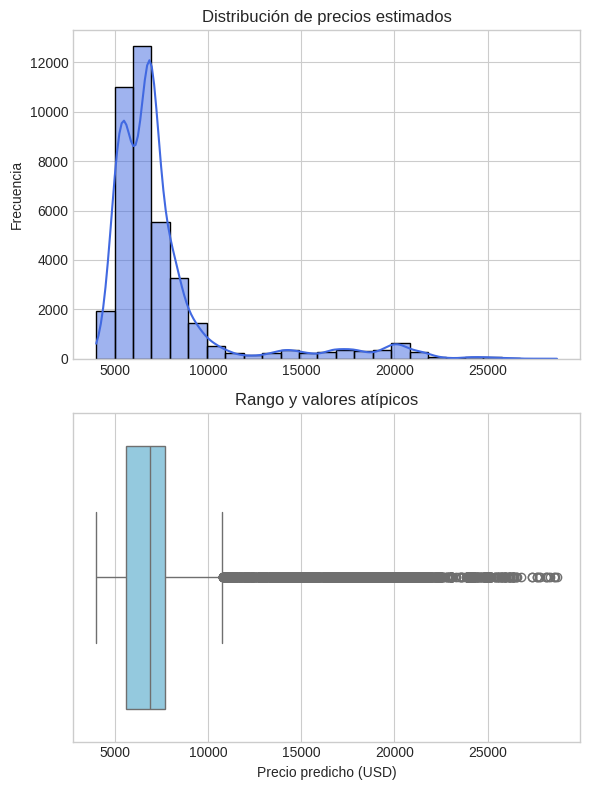

In [73]:
plt.figure(figsize=(6, 8))

# Histograma (arriba)
plt.subplot(2, 1, 1)
sns.histplot(df_out['Predicted Price (USD)'], bins=25, kde=True, color='royalblue')
plt.xlabel("")
plt.ylabel("Frecuencia")
plt.title("Distribución de precios estimados")

# Boxplot vertical (abajo)
plt.subplot(2, 1, 2)
sns.boxplot(x=df_out['Predicted Price (USD)'], color='skyblue')
plt.xlabel("Precio predicho (USD)")
plt.title("Rango y valores atípicos")

plt.tight_layout()
plt.savefig("predicted_prices_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
